## _Graph Construction_

- _Heuristic Method_

The terms _edges_ and _graph_ are used interchangeably.

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# append parent dir
sys.path.append('..')

In [6]:
# get cuda gpus if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# local imports
from src import SttCSVDataReader, SttTorchDataReader
from src import detector_layout
from src import Build_Event, Build_Event_Viz, Visualize_Edges
from src.math_utils import polar_to_cartesian

### _Input Data_

In [8]:
# input data
input_dir = '../data_all'

In [9]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

print("Number of Files: ", len(file_prefixes))

Number of Files:  100000


In [10]:
# file_prefixes[:10]

In [11]:
# load an event
# hits, tubes, particles, truth = trackml.dataset.load_event(file_prefixes[0])

In [12]:
# hits.head()
# tubes.head()
# particles.head()
# truth.head()

### _Visualize Event_

In [13]:
# select event
# event_id = 95191

In [14]:
# compose event is exactly the same as select_hits()
# event = Build_Event(input_dir, event_id, noise=False, skewed=False, selection=False)

In [15]:
# visualize event
# Build_Event_Viz(event, figsize=(10,10), fig_type="pdf", save_fig=False)

## _Heuristic Method_

Input graphs are input to a neural network, so they contain both _`True`_ and _`False`_ edges constructed by either a _heuristic method_ or _metric learning_. For supervised learning, we need node features (_`x`_), edge index (_`edge_index`_) and corresponding groud truth (_`y`_). 

Here we will explore a **_Heuristic Method_** to contruct input graphs.

In [16]:
from LightningModules.Processing.utils.event_utils import select_hits
from LightningModules.Processing.utils.event_utils import get_layerwise_edges
from LightningModules.Processing.utils.event_utils import get_modulewise_edges

In [17]:
# select an event
event_id = 95191
event_prefix = file_prefixes[event_id]

### _(1.) - Layerwise True Edges_

- _visualize layerwise true edges: `get_layerwise_edges()`_

In [18]:
# select hits
kwargs = {"selection": False}
event = select_hits(event_file=event_prefix, noise=False, skewed=False, **kwargs)

In [19]:
# layerwise true edges
layerwise_edges, event = get_layerwise_edges(event)

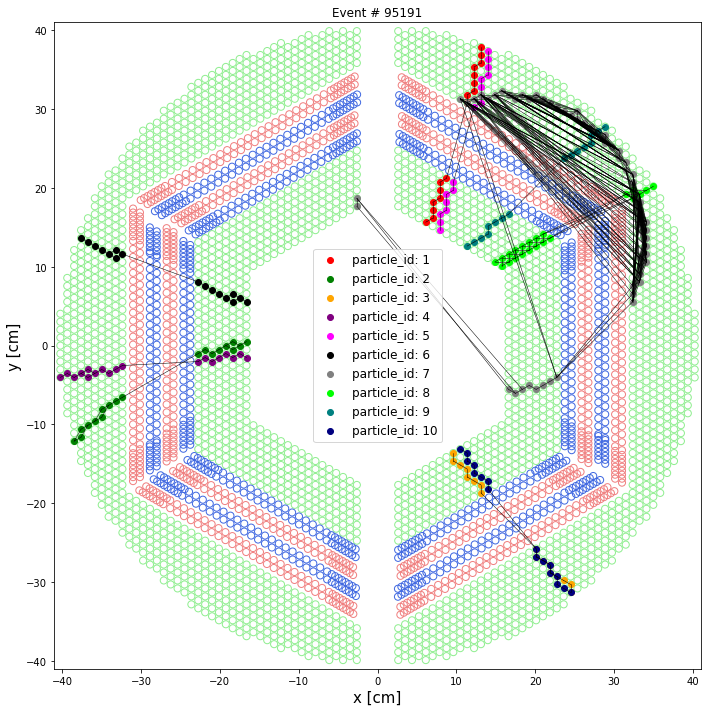

In [20]:
# visualize nodes & edges
Visualize_Edges (event, layerwise_edges, figsize=(10,10), fig_type="pdf", save_fig=False)

### _(2.) - Layerwise Heuristic for Input Edges_

**Input edges** are all possible edges containing both _`true`_ and _`fasle`_ edges in an event. Input edges are built from hits from all particles but in adjacent layers (_a.k.a **layerwise heuristic**_).

- _use `hits` from `get_layerwise_edges()`_
- _make `get_layerwise_input_edges()` function similar to `get_layerwise_edges()`_
- _add to PyG `Data` object._

In [21]:
# select hits
# kwargs = {"selection": False}
# event = select_hits(event_file=event_prefix, noise=False, skewed=False, **kwargs)

- _We will use `event` returned by `get_layerwise_edges()` instead from `select_hits()` since `get_layerwise_edges()` changes original order of `hits` in the DataFrame._

In [22]:
# event.head()

- _The `select_hits()` uses the `skewed` flag to **keep** or **remove** skewed layers, if `skewed=False` then layers from `8-15` are excluded from data giving discontinuous layer numbering in the column `layer_id`_
- _This discontinuity is problematic for graph construction where one loop over `layer_id` to either construct `true_edges` or `input_edges`, one needs to tackle this discontinuity in case `skewed=False`_
- _One way is to create some mask and be mindful of this issue, the other way is to re-number the `layer_id` to create a continuous layer number stored in a new column `layer`_
- _Whatever the solution we chose, layerwise graph construction depends on how `layer_pairs` are created. We can investigate this fact as two different cases in the following_

- _Case 1: When we have discontinuous sequence of layers_

In [23]:
# for skewed=False, discontinuous numbering of layers, sequence has missing layers from 8 to 15
# event.layer_id.unique()

In [24]:
# create adjacent layer pairs with discontinous sequence
# layers = event.layer_id.unique()
# layer_pairs = np.stack([layers[:-1], layers[1:]], axis=1)

In [25]:
# layer pairs
# layer_pairs

- _Case 2: When we have continuous (after renaming) sequence of layerse_

In [26]:
# for skewed=False, renumbered layers, the layers 16-25 are renamed as 8-17 creating continuous sequence
# event.layer.unique()

In [27]:
# get number of layers assuming continuous numbering
# n_layers = event.layer.unique().shape[0]
# layers = np.arange(n_layers)
# layer_pairs = np.stack([layers[:-1], layers[1:]], axis=1)

In [28]:
# layer pairs, now 7th layer is connected to 8th
# layer_pairs

- _To construct input edges in layerwise manner, first create layer pairs and get all `hits` in each layer `layer_groups` (sub-DataFrames), then merge both `layer_groups` together while adding `suffixes=('_1', '_2')`_
- _By collecting `index_1, index_2` from merged DataFrame (`hit_pairs`) infact create an `edges` between two nodes where one lies on one `layer` and the other lies to the next adjacent `layer`_

In [29]:
# get dataframe for each layer as layer_groups
layer_groups = event.groupby('layer')

In [30]:
# layer_groups.groups
# layer_groups.ngroups
# layer_groups.size()
# layer_groups.first()
# layer_groups.last()

In [31]:
# get group names
# layer_groups.groups.keys()
list(layer_groups.groups)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [32]:
# get a group
layer_groups.get_group(name=16)

,index,hit_id,x,y,z,volume_id,layer_id,module_id,isochrone,skewed,...,vy,vz,q,pdgcode,pt,ptheta,peta,pphi,event_id,R
210,210,234,-39.360901,-3.535000,35.0,9,24,4411,0.385239,0,...,0.0,0.0,1,13,1.092333,1.239707,0.337309,-2.989966,95191,52.789932
211,211,25,24.491199,-31.309999,35.0,9,24,4449,0.425081,0,...,0.0,0.0,-1,-13,1.409137,1.736451,-0.166417,-0.960231,95191,52.963524
212,212,260,24.491199,-31.309999,35.0,9,24,4449,0.390840,0,...,0.0,0.0,1,13,0.517704,0.673608,1.049408,-0.781997,95191,52.963524
213,213,208,13.995000,37.369999,35.0,9,24,4486,0.155016,0,...,0.0,0.0,1,13,0.322808,1.281874,0.293028,1.394635,95191,53.078968
216,216,313,13.120300,37.875000,35.0,9,24,4487,0.321512,0,...,0.0,0.0,1,13,0.847428,0.718148,0.979907,1.301192,95191,53.213326


In [33]:
# get layer pairs as ndarray, mind 'layer' column
n_layers = event.layer.unique().shape[0]
layers = np.arange(n_layers)
layer_pairs = np.stack([layers[:-1], layers[1:]], axis=1)

#### _(2.1) - Constructing Layerwise Input Edges_

- _loop over `layer_pairs` and extract subgroup of `hits` based on each `layer` in the form of `layer_groups`_

In [34]:
segments = []
layer_groups = event.groupby('layer')

for (l1, l2) in layer_pairs: # see above
    
    # check which layer pair is processing
    # print("constructing egdes for layer pair: ({}, {})".format(l1, l2))
    
    # get l1, l2 groups (DataFrames)
    lg1 = layer_groups.get_group(l1)
    lg2 = layer_groups.get_group(l2)   
    
    # get all possible pairs of hits
    keys = ['event_id', 'r', 'phi', 'isochrone', 'sector_id']
    hit_pairs = lg1[keys].reset_index().merge(lg2[keys].reset_index(), on='event_id', suffixes=('_1', '_2'))
    
    # construct edges
    edges = hit_pairs[['index_1', 'index_2']]
    
    # append edge list
    segments.append(edges)

In [35]:
# number of segments = number of layer pairs
len(segments)

17

In [36]:
# concatenate all segments
combined_segments = pd.concat(segments)
combined_segments.shape

(2855, 2)

In [37]:
# combined_segments.head()

In [38]:
# transform dataframe to numpy
layerwise_input_edges = combined_segments.to_numpy().T
layerwise_input_edges.shape

(2, 2855)

In [39]:
# layerwise_input_edges[:5]

In [40]:
# visualize nodes and edges
# Visualize_Edges (event, layerwise_input_edges, figsize=(10,10), fig_type="pdf", save_fig=False)

#### _(2.2) - Sector-wise Filtering_

- _To reduce number of edges, we can restrain edge construction in neighouring sectors by introducing condition as `|sector_id_i - sector_id_j| < 2`_

In [41]:
# lets take first layer_pair and corresponding hits
layer_pairs[0]

array([0, 1])

In [42]:
layer_groups = event.groupby('layer')

In [43]:
hits1 = layer_groups.get_group(0)
hits2 = layer_groups.get_group(1)

In [44]:
keys = ['event_id', 'r', 'phi', 'isochrone', 'sector_id']
hit_pairs = hits1[keys].reset_index().merge(hits2[keys].reset_index(), on='event_id', suffixes=('_1', '_2'))

In [45]:
# hit_pairs.head()

In [46]:
sector_mask = ((hit_pairs['sector_id_1'] - hit_pairs['sector_id_2']).abs() < 2)

In [47]:
sector_mask.shape

(144,)

In [48]:
hit_pairs[['index_1', 'index_2']].head()

,index_1,index_2
0,0,7
1,0,10
2,0,11
3,0,12
4,0,13


In [49]:
hit_pairs[['index_1', 'index_2']][sector_mask].head()

,index_1,index_2
0,0,7
1,0,10
7,0,23
9,0,28
14,1,11


In [50]:
segments = []
layer_groups = event.groupby('layer')
filtering = True

for (l1, l2) in layer_pairs: # see above
    
    # check which layer pair is processing
    # print("constructing egdes for layer pair: ({}, {})".format(l1, l2))
    
    # get l1, l2 groups (DataFrames)
    lg1 = layer_groups.get_group(l1)
    lg2 = layer_groups.get_group(l2)   
    
    # get all possible pairs of hits
    keys = ['event_id', 'r', 'phi', 'isochrone', 'sector_id']
    hit_pairs = lg1[keys].reset_index().merge(lg2[keys].reset_index(), on='event_id', suffixes=('_1', '_2'))
    
    # construct edges with/without sector constraint
    if filtering:
        dSector = (hit_pairs['sector_id_1'] - hit_pairs['sector_id_2'])
        sector_mask = ((dSector.abs() < 2) | (dSector.abs() == 5))
        edges = hit_pairs[['index_1', 'index_2']][sector_mask]
    else:
        edges = hit_pairs[['index_1', 'index_2']]
    
    # append edge list
    segments.append(edges)

In [51]:
# concatenate and transform
combined_segments = pd.concat(segments)
layerwise_input_edges = combined_segments.to_numpy().T

In [52]:
layerwise_input_edges.shape

(2, 1400)

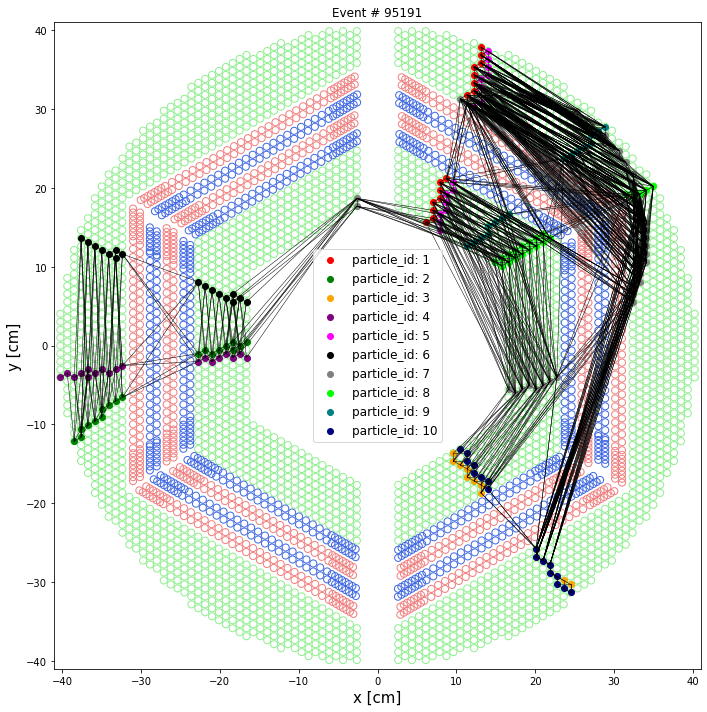

In [53]:
# visualize nodes and edges
Visualize_Edges (event, layerwise_input_edges, figsize=(10,10), fig_type="pdf", save_fig=False)

- _finally, to contruct layerwise input edges we have the following function in `graph_utils.py`_

In [54]:
# new naming scheme (layerwise, modulewise heuristics)
# layerwise_input_edges = get_layerwise_input_edges (hits, filtering=True)

### _(3.) - Modulewise True Edges_

- _visualize modulewise true edges: `get_modulewise_edges()`_

In [55]:
# select hits
kwargs = {"selection": False}
event = select_hits(event_file=event_prefix, noise=False, skewed=False, **kwargs)

In [56]:
# modulewise true edges
modulewise_edges = get_modulewise_edges(event)

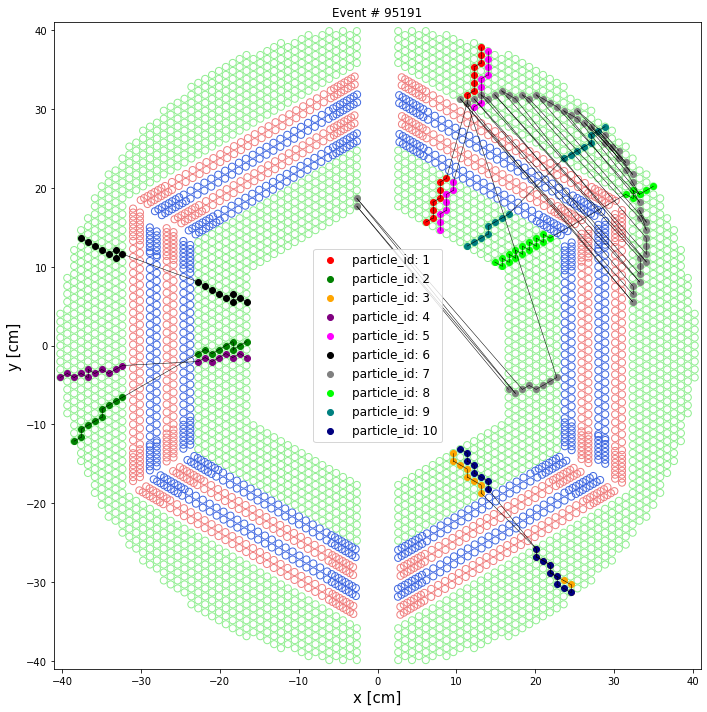

In [57]:
# visualize nodes & edges
Visualize_Edges (event, modulewise_edges, figsize=(10,10), fig_type="pdf", save_fig=False)

### _(4.) - Modulewise Heuristic for Input Edges_

**Input edges** are all possible edges containing both _`true`_ and _`fasle`_ edges in an event. Input edges are built from hits from all particles without any sense of layers (_a.k.a **modulewise heuristic**_).

- _use `hits` from `get_modulewise_edges()`_
- _make `get_modulewise_input_edges()` function similar to `get_modulewise_edges()`_
- _add to PyG `Data` object._

In [58]:
# select hits
kwargs = {"selection": False}
hits = select_hits(event_file=event_prefix, noise=False, skewed=False, **kwargs)

- _investigate **particle pairs**_

In [59]:
# groupby particle_id
# pid_groups = hits.groupby("particle_id", sort=True)

In [60]:
# create particle pairs
pids = hits.particle_id.unique()
pid_pairs = np.stack([pids[:-1], pids[1:]], axis=1)

In [61]:
# content of particle pairs
pid_pairs

array([[10,  9],
       [ 9,  8],
       [ 8,  7],
       [ 7,  6],
       [ 6,  5],
       [ 5,  4],
       [ 4,  3],
       [ 3,  2],
       [ 2,  1]])

- _investigate **layer pairs**_

In [62]:
# create layer groups
# layer_groups = hits.groupby('layer')

In [63]:
# create layer pairs
layers = hits.layer_id.unique()
layer_pairs = np.stack([layers[:-1], layers[1:]], axis=1)

In [64]:
# content of layer pairs
layer_pairs

array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7, 16],
       [16, 17],
       [17, 18],
       [18, 19],
       [19, 20],
       [20, 21],
       [21, 22],
       [22, 23],
       [23, 24],
       [24, 25]], dtype=int32)

#### _(4.1) - Constructing Modulewise Input Edges_

- _first get module list not based on filtering with respect to `layer_id` or `particle_id`_
- _follow the same logic of `get_modulewise_edges()`, remove restrict on `particle_id` and contruct edges_

In [65]:
# Handle NaN and Null Values
signal = hits[
    ((~hits.particle_id.isna()) & (hits.particle_id != 0)) & (~hits.vx.isna())
]
signal = signal.drop_duplicates(
    subset=["particle_id", "volume_id", "layer_id", "module_id"]
)

# Handle Indexing (Keep order of occurrence)
signal = signal.reset_index()

# Rename 'index' column to 'unsorted_index'
signal = signal.rename(columns={"index": "unsorted_index"}).reset_index(drop=False)

# Handle Particle_id 0
signal.loc[signal["particle_id"] == 0, "particle_id"] = np.nan

In [66]:
# this is layerwise input edges code
segments = []
layer_groups = signal.groupby('layer_id')
filtering = True

for (l1, l2) in layer_pairs:
    print("processing layer pair: ({}, {})".format(l1, l2))
    
    # get l1, l2 groups (DataFrames)
    lg1 = layer_groups.get_group(l1)
    lg2 = layer_groups.get_group(l2)   
    
    # Start with all possible pairs of hits
    keys = ['event_id', 'r', 'phi', 'isochrone', 'sector_id']
    hit_pairs = lg1[keys].reset_index().merge(lg2[keys].reset_index(), on='event_id', suffixes=('_1', '_2'))
    
    if filtering:
        dSector = (hit_pairs['sector_id_1'] - hit_pairs['sector_id_2'])
        sector_mask = ((dSector.abs() < 2) | (dSector.abs() == 5))
        e = hit_pairs[['index_1', 'index_2']][sector_mask]
    else:
        e = hit_pairs[['index_1', 'index_2']]
        
    segments.append(e)

processing layer pair: (0, 1)
processing layer pair: (1, 2)
processing layer pair: (2, 3)
processing layer pair: (3, 4)
processing layer pair: (4, 5)
processing layer pair: (5, 6)
processing layer pair: (6, 7)
processing layer pair: (7, 16)
processing layer pair: (16, 17)
processing layer pair: (17, 18)
processing layer pair: (18, 19)
processing layer pair: (19, 20)
processing layer pair: (20, 21)
processing layer pair: (21, 22)
processing layer pair: (22, 23)
processing layer pair: (23, 24)
processing layer pair: (24, 25)


In [67]:
len(segments)

17

In [68]:
# concatenate and transform
combined_segments = pd.concat(segments)
modulewise_input_edges = combined_segments.to_numpy().T

In [69]:
modulewise_input_edges.shape

(2, 1400)

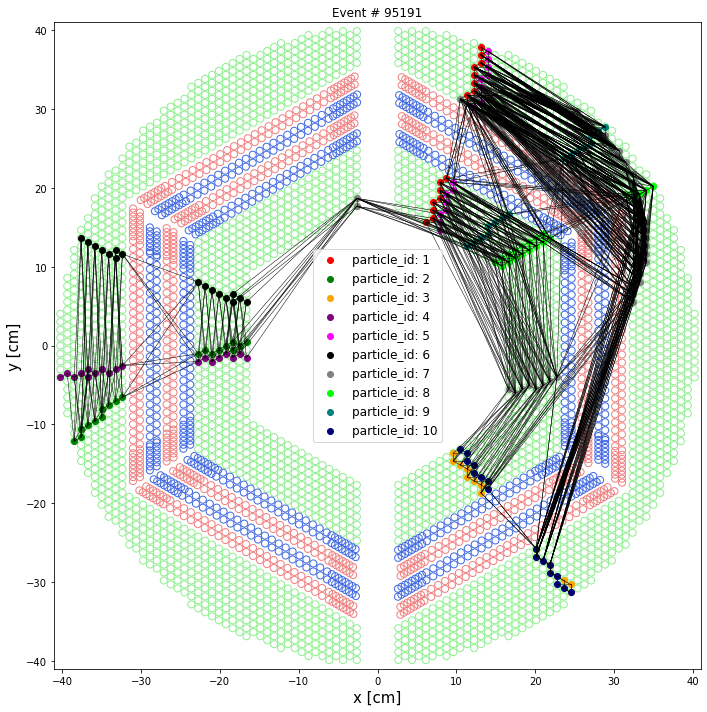

In [70]:
# visualize nodes and edges
Visualize_Edges (signal, modulewise_input_edges, figsize=(10,10), fig_type="pdf", save_fig=True)